<a href="https://colab.research.google.com/github/ichiyan/BrainDecoding/blob/master/sd_pretrained_autoencoder_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!nvidia-smi

Thu Dec  8 22:08:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 24.7 MB/s 
     |████████████████████████████████| 182 kB 68.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 23.1 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 7.6 MB 66.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.9 MB/s 


In [9]:
# import os
# from PIL import Image, ImageDraw
# import cv2
# import numpy as np
# from IPython.display import HTML
# from base64 import b64encode

# import torch
# from torch import autocast
# from torch.nn import functional as F
# from diffusers import StableDiffusionPipeline, AutoencoderKL
# from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
# from diffusers.schedulers.scheduling_ddim import DDIMScheduler
# from transformers import CLIPTextModel, CLIPTokenizer
# from tqdm.auto import tqdm

import numpy as np
import torch
from diffusers import AutoencoderKL
from PIL import Image
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [10]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae = vae.to(device)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [11]:
def encode_img_latents(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]

  img_arr = np.stack([np.array(img) for img in imgs], axis=0)
  img_arr = img_arr / 255.0
  img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
  img_arr = 2 * (img_arr - 0.5)

  img_arr

  latent_dists = vae.encode(img_arr.to(device))
  latent_samples = latent_dists.sample()
  latent_samples *= 0.18215

  return latent_dists, latent_samples

In [12]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)

  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

In [ ]:
from google.colab import files

img_upload = files.upload()
# only tested a few DIR images
# try uploading DIR images with people to see difference in decoded image 

In [ ]:
img = Image.open(list(img_upload.keys())[0])
# DIR images size is 500 x 500. If not resized to 512 x 512, decoded image size is ~ 496 x 496
# TODO: make decoded img size 500 x 500 as well if resizing should not be done 
img= img.resize((512, 512))
# image type must be PIL Image object
type(img)



PIL.Image.Image

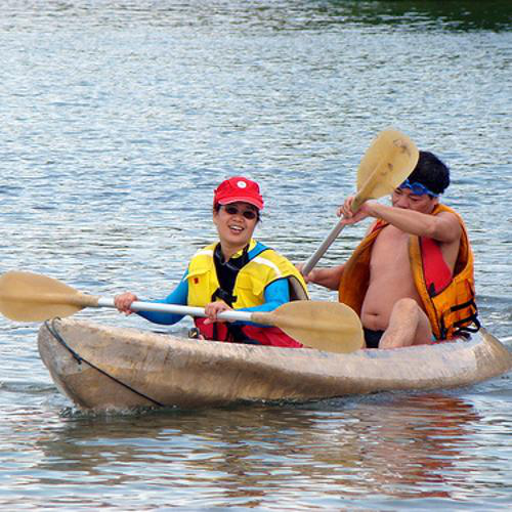

In [ ]:
img

In [ ]:
img_dist, img_latents = encode_img_latents([img])
type(img_latents)

torch.Tensor

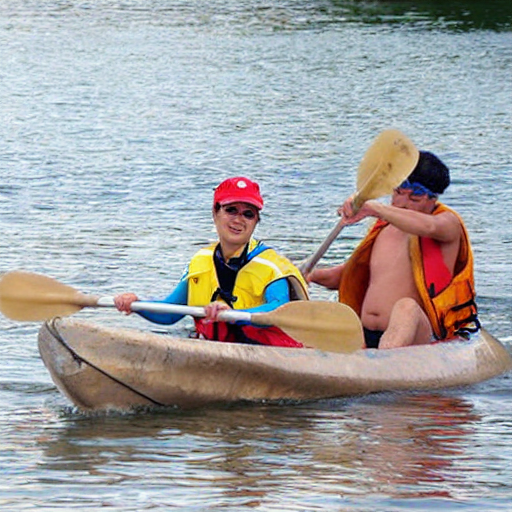

In [ ]:
dec_img = decode_img_latents(img_latents)[0]
dec_img

In [ ]:
dec_img.size

(512, 512)

In [ ]:
!pip install image-similarity-measures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import ssim, rmse

In [ ]:
orig = np.array(img)
pred = np.array(dec_img)
ssim(orig, pred)

0.9831717522426805

In [ ]:
rmse(orig, pred)

0.004108865

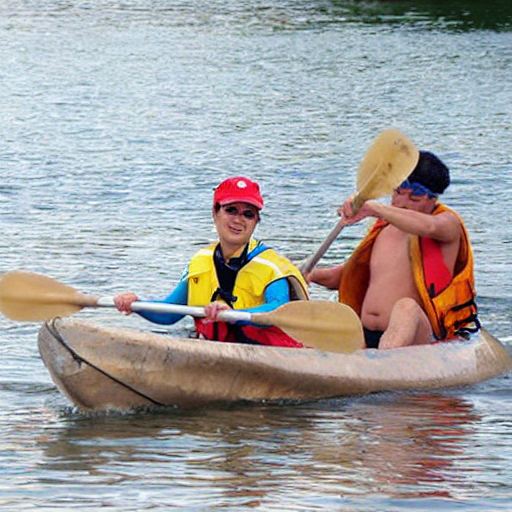

In [ ]:
latent_samples = img_dist.sample()
latent_samples *= 0.18215

new_dec_img = decode_img_latents(latent_samples)[0]
new_dec_img

In [ ]:
orig = np.array(dec_img)
pred = np.array(new_dec_img)
ssim(orig, pred)

0.9999980610458657

In [ ]:
rmse(orig, pred)

4.278694e-05

# Test NSD

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import h5py

In [3]:
root_path = 'gdrive/My Drive/coding_projects/brain_decoding/'
data_path = root_path + 'data/NSD/'

In [5]:
f = h5py.File(data_path + 'subj01_nsdgeneral.hdf5')
voxels = f['voxels']
images = f['images']
print(voxels.shape, images.shape)

(27750, 15724) (27750, 256, 256, 3)


<class 'PIL.Image.Image'>


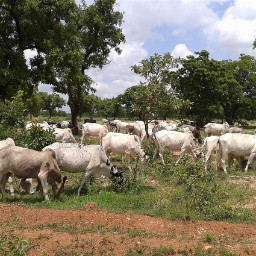

In [28]:
image = images[0].astype(np.uint8)
image_pil = Image.fromarray(image)
print(type(image_pil))
image_pil

In [29]:
img_dist, img_latents = encode_img_latents([image_pil])
print(type(img_latents))
print(img_latents[0].shape)

<class 'torch.Tensor'>
torch.Size([4, 32, 32])


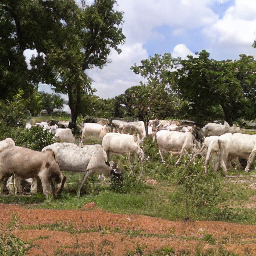

In [30]:
dec_img = decode_img_latents(img_latents)[0]
dec_img

TODO:
- plot other images